In [1]:
import dash
import plotly
from dash.dependencies import  Output, Input
import dash_core_components as dcc
import dash_html_components as html
import dash_table
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import plotly.express as px
import scipy
import scipy.spatial
import dash_daq as daq
import base64

from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [47]:
clusters2 = pd.read_csv("clusters2_with_stats.csv")
clusters2 = clusters2.drop(['Unnamed: 0'],axis=1)

In [48]:
players = clusters2['Player']
GMM_Cluster = pd.DataFrame(clusters2['GMM_Cluster'])
clusters2 = clusters2.drop(['Player', 'GMM_Cluster'],axis=1)

In [49]:
data=clusters2

In [50]:
for i in range(0, data.shape[1]):
    data.iloc[:,i] = (data.iloc[:,i] - data.iloc[:,i].min() ) / ( data.iloc[:,i].max() - data.iloc[:,i].min())

In [51]:
data_subset = data.values

In [55]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(data_subset)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 709 samples in 0.001s...
[t-SNE] Computed neighbors for 709 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 709 / 709
[t-SNE] Mean sigma: 0.293747
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.969582
[t-SNE] KL divergence after 1000 iterations: 1.158504


In [56]:
GMM_Cluster['tsne-2d-one'] = tsne_results[:,0]
GMM_Cluster['tsne-2d-two'] = tsne_results[:,1]
GMM_Cluster=GMM_Cluster.rename(columns={'GMM_Cluster':'y'})

In [61]:
len(GMM_Cluster['y'].unique())

23

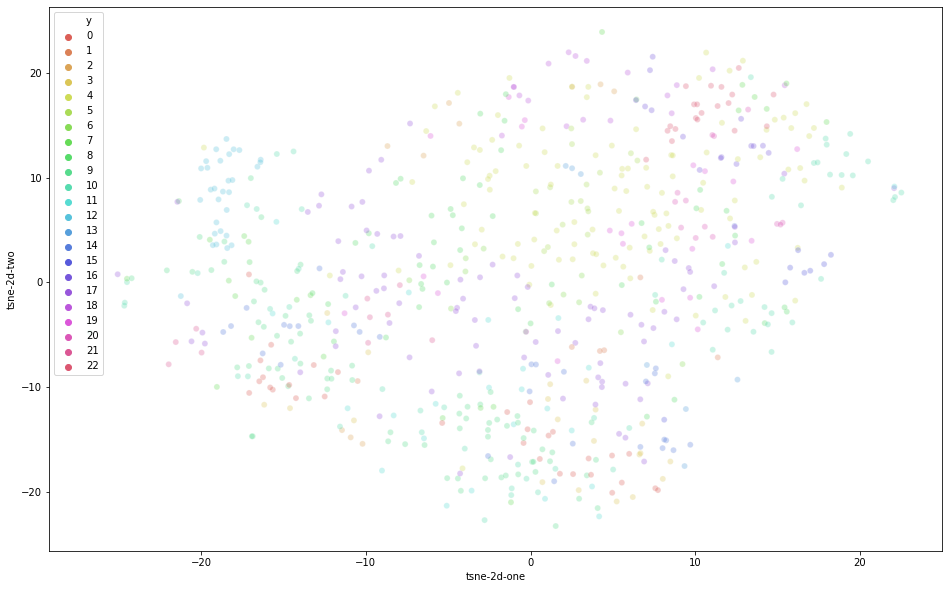

In [62]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 23),
    data=GMM_Cluster,
    legend="full",
    alpha=0.3
)

In [75]:
import numpy as np
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

In [77]:
MACHINE_EPSILON = np.finfo(np.double).eps
n_components = 2
perplexity = 30

In [85]:
clusters2 = pd.read_csv("clusters2_with_stats.csv")
clusters2 = clusters2.drop(['Unnamed: 0'],axis=1)

players = clusters2['Player']
GMM_Cluster = pd.DataFrame(clusters2['GMM_Cluster'])
clusters2 = clusters2.drop(['Player', 'GMM_Cluster'],axis=1)

data=clusters2

for i in range(0, data.shape[1]):
    data.iloc[:,i] = (data.iloc[:,i] - data.iloc[:,i].min() ) / ( data.iloc[:,i].max() - data.iloc[:,i].min())

In [87]:
data.head(1)

,Goals per 90,Head goals per 90,Assists per 90,Crosses per 90,Touches in box per 90,Progressive runs per 90,Succ. def. per 90,Shots blocked per 90,Second assists per 90,Third assists per 90,...,Dribbles succ. per 90,Def duels won per 90,Aerial duels won per 90,Tackle succ per 90,Smt passes acc. per 90,Final 3rd passes acc per90,Thru passes acc per 90,Deep completed passes acc per 90,Deep completed crosses acc per 90,Fwd passes acc per 90
0,0.208696,0.0,0.096774,0.320475,0.309192,0.291312,0.321483,0.037736,0.056604,0.0,...,0.501133,0.474171,0.105569,0.046866,0.144189,0.129546,0.1611,0.205172,0.2351,0.15839


In [ ]:
X=data

In [65]:
def fit(X):
    n_samples = X.shape[0]
    
    # Compute euclidean distance
    distances = pairwise_distances(X, metric='euclidean', squared=True)
    
    # Compute joint probabilities p_ij from distances.
    P = _joint_probabilities(distances=distances, desired_perplexity=perplexity, verbose=False)
    
    # The embedding is initialized with iid samples from Gaussians with standard deviation 1e-4.
    X_embedded = 1e-4 * np.random.mtrand._rand.randn(n_samples, n_components).astype(np.float32)
    
    # degrees_of_freedom = n_components - 1 comes from
    # "Learning a Parametric Embedding by Preserving Local Structure"
    # Laurens van der Maaten, 2009.
    degrees_of_freedom = max(n_components - 1, 1)
    
    return _tsne(P, degrees_of_freedom, n_samples, X_embedded=X_embedded)

In [68]:
def _tsne(P, degrees_of_freedom, n_samples, X_embedded):
    params = X_embedded.ravel()
    
    obj_func = _kl_divergence
    
    params = _gradient_descent(obj_func, params, [P, degrees_of_freedom, n_samples, n_components])
        
    X_embedded = params.reshape(n_samples, n_components)
    return X_embedded

In [69]:
def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components):
    X_embedded = params.reshape(n_samples, n_components)
    
    dist = pdist(X_embedded, "sqeuclidean")
    dist /= degrees_of_freedom
    dist += 1.
    dist **= (degrees_of_freedom + 1.0) / -2.0
    Q = np.maximum(dist / (2.0 * np.sum(dist)), MACHINE_EPSILON)
    
    # Kullback-Leibler divergence of P and Q
    kl_divergence = 2.0 * np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    
    # Gradient: dC/dY
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist)
    for i in range(n_samples):
        grad[i] = np.dot(np.ravel(PQd[i], order='K'),
                         X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad *= c
    return kl_divergence, grad

In [92]:
def _gradient_descent(obj_func, p0, args, it=0, n_iter=1500, n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=300.0, min_gain=0.05,
                      min_grad_norm=1e-7):
    
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it
    
    for i in range(it, n_iter):
        error, grad = obj_func(p, *args)
        grad_norm = linalg.norm(grad)
        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update
        print("[t-SNE] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      % (i + 1, error, grad_norm))
        
        if error < best_error:
                best_error = error
                best_iter = i
        elif i - best_iter > n_iter_without_progress:
            break
        
        if grad_norm <= min_grad_norm:
            break
    return p

In [93]:
X=data

In [94]:
X_embedded = fit(X)

[t-SNE] Iteration 1: error = 2.9400455, gradient norm = 0.0000093
[t-SNE] Iteration 2: error = 2.9400455, gradient norm = 0.0000112
[t-SNE] Iteration 3: error = 2.9400455, gradient norm = 0.0000229
[t-SNE] Iteration 4: error = 2.9400450, gradient norm = 0.0000596
[t-SNE] Iteration 5: error = 2.9400412, gradient norm = 0.0001787
[t-SNE] Iteration 6: error = 2.9399991, gradient norm = 0.0005979
[t-SNE] Iteration 7: error = 2.9394430, gradient norm = 0.0021920
[t-SNE] Iteration 8: error = 2.9310273, gradient norm = 0.0082244
[t-SNE] Iteration 9: error = 2.8343552, gradient norm = 0.0193846
[t-SNE] Iteration 10: error = 2.5197753, gradient norm = 0.0198884
[t-SNE] Iteration 11: error = 2.2092281, gradient norm = 0.0140603
[t-SNE] Iteration 12: error = 2.0133951, gradient norm = 0.0114754
[t-SNE] Iteration 13: error = 1.8722314, gradient norm = 0.0100433
[t-SNE] Iteration 14: error = 1.7618328, gradient norm = 0.0091171
[t-SNE] Iteration 15: error = 1.6804150, gradient norm = 0.0081604
[t-S

[t-SNE] Iteration 125: error = 1.2949389, gradient norm = 0.0005393
[t-SNE] Iteration 126: error = 1.2945878, gradient norm = 0.0005069
[t-SNE] Iteration 127: error = 1.2942718, gradient norm = 0.0005358
[t-SNE] Iteration 128: error = 1.2939067, gradient norm = 0.0004805
[t-SNE] Iteration 129: error = 1.2936595, gradient norm = 0.0004653
[t-SNE] Iteration 130: error = 1.2934736, gradient norm = 0.0005181
[t-SNE] Iteration 131: error = 1.2931955, gradient norm = 0.0004624
[t-SNE] Iteration 132: error = 1.2929010, gradient norm = 0.0003621
[t-SNE] Iteration 133: error = 1.2926654, gradient norm = 0.0003273
[t-SNE] Iteration 134: error = 1.2924768, gradient norm = 0.0003460
[t-SNE] Iteration 135: error = 1.2922902, gradient norm = 0.0003480
[t-SNE] Iteration 136: error = 1.2920882, gradient norm = 0.0003123
[t-SNE] Iteration 137: error = 1.2918834, gradient norm = 0.0002814
[t-SNE] Iteration 138: error = 1.2916884, gradient norm = 0.0002415
[t-SNE] Iteration 139: error = 1.2915208, gradie

[t-SNE] Iteration 249: error = 1.2807145, gradient norm = 0.0000884
[t-SNE] Iteration 250: error = 1.2806315, gradient norm = 0.0000926
[t-SNE] Iteration 251: error = 1.2805498, gradient norm = 0.0000976
[t-SNE] Iteration 252: error = 1.2804710, gradient norm = 0.0001047
[t-SNE] Iteration 253: error = 1.2803947, gradient norm = 0.0001093
[t-SNE] Iteration 254: error = 1.2803185, gradient norm = 0.0001160
[t-SNE] Iteration 255: error = 1.2802372, gradient norm = 0.0001244
[t-SNE] Iteration 256: error = 1.2801451, gradient norm = 0.0001294
[t-SNE] Iteration 257: error = 1.2800415, gradient norm = 0.0001309
[t-SNE] Iteration 258: error = 1.2799301, gradient norm = 0.0001299
[t-SNE] Iteration 259: error = 1.2798163, gradient norm = 0.0001254
[t-SNE] Iteration 260: error = 1.2797042, gradient norm = 0.0001218
[t-SNE] Iteration 261: error = 1.2795938, gradient norm = 0.0001198
[t-SNE] Iteration 262: error = 1.2794832, gradient norm = 0.0001231
[t-SNE] Iteration 263: error = 1.2793685, gradie

[t-SNE] Iteration 373: error = 1.2721510, gradient norm = 0.0001964
[t-SNE] Iteration 374: error = 1.2721119, gradient norm = 0.0001575
[t-SNE] Iteration 375: error = 1.2720784, gradient norm = 0.0001353
[t-SNE] Iteration 376: error = 1.2720494, gradient norm = 0.0001385
[t-SNE] Iteration 377: error = 1.2720212, gradient norm = 0.0001360
[t-SNE] Iteration 378: error = 1.2719936, gradient norm = 0.0001232
[t-SNE] Iteration 379: error = 1.2719683, gradient norm = 0.0001118
[t-SNE] Iteration 380: error = 1.2719454, gradient norm = 0.0001070
[t-SNE] Iteration 381: error = 1.2719240, gradient norm = 0.0001046
[t-SNE] Iteration 382: error = 1.2719038, gradient norm = 0.0001015
[t-SNE] Iteration 383: error = 1.2718842, gradient norm = 0.0000940
[t-SNE] Iteration 384: error = 1.2718655, gradient norm = 0.0000844
[t-SNE] Iteration 385: error = 1.2718481, gradient norm = 0.0000799
[t-SNE] Iteration 386: error = 1.2718319, gradient norm = 0.0000796
[t-SNE] Iteration 387: error = 1.2718160, gradie

[t-SNE] Iteration 497: error = 1.2711492, gradient norm = 0.0000170
[t-SNE] Iteration 498: error = 1.2711457, gradient norm = 0.0000177
[t-SNE] Iteration 499: error = 1.2711422, gradient norm = 0.0000179
[t-SNE] Iteration 500: error = 1.2711387, gradient norm = 0.0000192
[t-SNE] Iteration 501: error = 1.2711352, gradient norm = 0.0000185
[t-SNE] Iteration 502: error = 1.2711317, gradient norm = 0.0000194
[t-SNE] Iteration 503: error = 1.2711282, gradient norm = 0.0000218
[t-SNE] Iteration 504: error = 1.2711247, gradient norm = 0.0000221
[t-SNE] Iteration 505: error = 1.2711211, gradient norm = 0.0000209
[t-SNE] Iteration 506: error = 1.2711176, gradient norm = 0.0000214
[t-SNE] Iteration 507: error = 1.2711141, gradient norm = 0.0000205
[t-SNE] Iteration 508: error = 1.2711106, gradient norm = 0.0000192
[t-SNE] Iteration 509: error = 1.2711071, gradient norm = 0.0000207
[t-SNE] Iteration 510: error = 1.2711036, gradient norm = 0.0000198
[t-SNE] Iteration 511: error = 1.2711001, gradie

[t-SNE] Iteration 618: error = 1.2696821, gradient norm = 0.0000134
[t-SNE] Iteration 619: error = 1.2696805, gradient norm = 0.0000141
[t-SNE] Iteration 620: error = 1.2696789, gradient norm = 0.0000137
[t-SNE] Iteration 621: error = 1.2696773, gradient norm = 0.0000129
[t-SNE] Iteration 622: error = 1.2696757, gradient norm = 0.0000127
[t-SNE] Iteration 623: error = 1.2696741, gradient norm = 0.0000127
[t-SNE] Iteration 624: error = 1.2696725, gradient norm = 0.0000128
[t-SNE] Iteration 625: error = 1.2696709, gradient norm = 0.0000129
[t-SNE] Iteration 626: error = 1.2696694, gradient norm = 0.0000127
[t-SNE] Iteration 627: error = 1.2696678, gradient norm = 0.0000129
[t-SNE] Iteration 628: error = 1.2696663, gradient norm = 0.0000127
[t-SNE] Iteration 629: error = 1.2696648, gradient norm = 0.0000131
[t-SNE] Iteration 630: error = 1.2696632, gradient norm = 0.0000128
[t-SNE] Iteration 631: error = 1.2696617, gradient norm = 0.0000126
[t-SNE] Iteration 632: error = 1.2696602, gradie

[t-SNE] Iteration 741: error = 1.2695282, gradient norm = 0.0000097
[t-SNE] Iteration 742: error = 1.2695273, gradient norm = 0.0000096
[t-SNE] Iteration 743: error = 1.2695264, gradient norm = 0.0000095
[t-SNE] Iteration 744: error = 1.2695255, gradient norm = 0.0000097
[t-SNE] Iteration 745: error = 1.2695245, gradient norm = 0.0000095
[t-SNE] Iteration 746: error = 1.2695236, gradient norm = 0.0000091
[t-SNE] Iteration 747: error = 1.2695227, gradient norm = 0.0000091
[t-SNE] Iteration 748: error = 1.2695218, gradient norm = 0.0000091
[t-SNE] Iteration 749: error = 1.2695209, gradient norm = 0.0000091
[t-SNE] Iteration 750: error = 1.2695200, gradient norm = 0.0000093
[t-SNE] Iteration 751: error = 1.2695191, gradient norm = 0.0000094
[t-SNE] Iteration 752: error = 1.2695182, gradient norm = 0.0000092
[t-SNE] Iteration 753: error = 1.2695173, gradient norm = 0.0000091
[t-SNE] Iteration 754: error = 1.2695164, gradient norm = 0.0000093
[t-SNE] Iteration 755: error = 1.2695155, gradie

[t-SNE] Iteration 863: error = 1.2691292, gradient norm = 0.0000586
[t-SNE] Iteration 864: error = 1.2691216, gradient norm = 0.0000551
[t-SNE] Iteration 865: error = 1.2691148, gradient norm = 0.0000543
[t-SNE] Iteration 866: error = 1.2691082, gradient norm = 0.0000542
[t-SNE] Iteration 867: error = 1.2691013, gradient norm = 0.0000534
[t-SNE] Iteration 868: error = 1.2690939, gradient norm = 0.0000518
[t-SNE] Iteration 869: error = 1.2690860, gradient norm = 0.0000499
[t-SNE] Iteration 870: error = 1.2690780, gradient norm = 0.0000486
[t-SNE] Iteration 871: error = 1.2690707, gradient norm = 0.0000489
[t-SNE] Iteration 872: error = 1.2690642, gradient norm = 0.0000503
[t-SNE] Iteration 873: error = 1.2690582, gradient norm = 0.0000514
[t-SNE] Iteration 874: error = 1.2690523, gradient norm = 0.0000508
[t-SNE] Iteration 875: error = 1.2690461, gradient norm = 0.0000484
[t-SNE] Iteration 876: error = 1.2690398, gradient norm = 0.0000461
[t-SNE] Iteration 877: error = 1.2690334, gradie

[t-SNE] Iteration 984: error = 1.2677988, gradient norm = 0.0000118
[t-SNE] Iteration 985: error = 1.2677979, gradient norm = 0.0000117
[t-SNE] Iteration 986: error = 1.2677971, gradient norm = 0.0000115
[t-SNE] Iteration 987: error = 1.2677962, gradient norm = 0.0000114
[t-SNE] Iteration 988: error = 1.2677953, gradient norm = 0.0000114
[t-SNE] Iteration 989: error = 1.2677943, gradient norm = 0.0000113
[t-SNE] Iteration 990: error = 1.2677933, gradient norm = 0.0000114
[t-SNE] Iteration 991: error = 1.2677922, gradient norm = 0.0000121
[t-SNE] Iteration 992: error = 1.2677911, gradient norm = 0.0000141
[t-SNE] Iteration 993: error = 1.2677899, gradient norm = 0.0000137
[t-SNE] Iteration 994: error = 1.2677885, gradient norm = 0.0000124
[t-SNE] Iteration 995: error = 1.2677871, gradient norm = 0.0000125
[t-SNE] Iteration 996: error = 1.2677856, gradient norm = 0.0000134
[t-SNE] Iteration 997: error = 1.2677840, gradient norm = 0.0000141
[t-SNE] Iteration 998: error = 1.2677821, gradie

[t-SNE] Iteration 1105: error = 1.2676118, gradient norm = 0.0000061
[t-SNE] Iteration 1106: error = 1.2676114, gradient norm = 0.0000064
[t-SNE] Iteration 1107: error = 1.2676110, gradient norm = 0.0000066
[t-SNE] Iteration 1108: error = 1.2676106, gradient norm = 0.0000064
[t-SNE] Iteration 1109: error = 1.2676102, gradient norm = 0.0000060
[t-SNE] Iteration 1110: error = 1.2676099, gradient norm = 0.0000060
[t-SNE] Iteration 1111: error = 1.2676095, gradient norm = 0.0000062
[t-SNE] Iteration 1112: error = 1.2676091, gradient norm = 0.0000058
[t-SNE] Iteration 1113: error = 1.2676088, gradient norm = 0.0000059
[t-SNE] Iteration 1114: error = 1.2676084, gradient norm = 0.0000063
[t-SNE] Iteration 1115: error = 1.2676080, gradient norm = 0.0000065
[t-SNE] Iteration 1116: error = 1.2676076, gradient norm = 0.0000065
[t-SNE] Iteration 1117: error = 1.2676073, gradient norm = 0.0000063
[t-SNE] Iteration 1118: error = 1.2676069, gradient norm = 0.0000064
[t-SNE] Iteration 1119: error = 1.

[t-SNE] Iteration 1224: error = 1.2675745, gradient norm = 0.0000055
[t-SNE] Iteration 1225: error = 1.2675743, gradient norm = 0.0000051
[t-SNE] Iteration 1226: error = 1.2675740, gradient norm = 0.0000049
[t-SNE] Iteration 1227: error = 1.2675738, gradient norm = 0.0000051
[t-SNE] Iteration 1228: error = 1.2675735, gradient norm = 0.0000052
[t-SNE] Iteration 1229: error = 1.2675733, gradient norm = 0.0000053
[t-SNE] Iteration 1230: error = 1.2675730, gradient norm = 0.0000054
[t-SNE] Iteration 1231: error = 1.2675728, gradient norm = 0.0000050
[t-SNE] Iteration 1232: error = 1.2675725, gradient norm = 0.0000051
[t-SNE] Iteration 1233: error = 1.2675723, gradient norm = 0.0000051
[t-SNE] Iteration 1234: error = 1.2675720, gradient norm = 0.0000051
[t-SNE] Iteration 1235: error = 1.2675718, gradient norm = 0.0000054
[t-SNE] Iteration 1236: error = 1.2675715, gradient norm = 0.0000053
[t-SNE] Iteration 1237: error = 1.2675713, gradient norm = 0.0000053
[t-SNE] Iteration 1238: error = 1.

[t-SNE] Iteration 1347: error = 1.2675485, gradient norm = 0.0000044
[t-SNE] Iteration 1348: error = 1.2675483, gradient norm = 0.0000051
[t-SNE] Iteration 1349: error = 1.2675481, gradient norm = 0.0000045
[t-SNE] Iteration 1350: error = 1.2675480, gradient norm = 0.0000044
[t-SNE] Iteration 1351: error = 1.2675478, gradient norm = 0.0000045
[t-SNE] Iteration 1352: error = 1.2675476, gradient norm = 0.0000043
[t-SNE] Iteration 1353: error = 1.2675474, gradient norm = 0.0000044
[t-SNE] Iteration 1354: error = 1.2675473, gradient norm = 0.0000043
[t-SNE] Iteration 1355: error = 1.2675471, gradient norm = 0.0000044
[t-SNE] Iteration 1356: error = 1.2675469, gradient norm = 0.0000048
[t-SNE] Iteration 1357: error = 1.2675468, gradient norm = 0.0000052
[t-SNE] Iteration 1358: error = 1.2675466, gradient norm = 0.0000051
[t-SNE] Iteration 1359: error = 1.2675464, gradient norm = 0.0000051
[t-SNE] Iteration 1360: error = 1.2675462, gradient norm = 0.0000045
[t-SNE] Iteration 1361: error = 1.

[t-SNE] Iteration 1471: error = 1.2675299, gradient norm = 0.0000037
[t-SNE] Iteration 1472: error = 1.2675298, gradient norm = 0.0000037
[t-SNE] Iteration 1473: error = 1.2675297, gradient norm = 0.0000036
[t-SNE] Iteration 1474: error = 1.2675296, gradient norm = 0.0000037
[t-SNE] Iteration 1475: error = 1.2675294, gradient norm = 0.0000035
[t-SNE] Iteration 1476: error = 1.2675293, gradient norm = 0.0000035
[t-SNE] Iteration 1477: error = 1.2675292, gradient norm = 0.0000036
[t-SNE] Iteration 1478: error = 1.2675291, gradient norm = 0.0000035
[t-SNE] Iteration 1479: error = 1.2675289, gradient norm = 0.0000036
[t-SNE] Iteration 1480: error = 1.2675288, gradient norm = 0.0000035
[t-SNE] Iteration 1481: error = 1.2675287, gradient norm = 0.0000034
[t-SNE] Iteration 1482: error = 1.2675286, gradient norm = 0.0000037
[t-SNE] Iteration 1483: error = 1.2675284, gradient norm = 0.0000039
[t-SNE] Iteration 1484: error = 1.2675283, gradient norm = 0.0000039
[t-SNE] Iteration 1485: error = 1.

[t-SNE] Iteration 1592: error = 1.2675165, gradient norm = 0.0000029
[t-SNE] Iteration 1593: error = 1.2675164, gradient norm = 0.0000030
[t-SNE] Iteration 1594: error = 1.2675163, gradient norm = 0.0000029
[t-SNE] Iteration 1595: error = 1.2675163, gradient norm = 0.0000030
[t-SNE] Iteration 1596: error = 1.2675162, gradient norm = 0.0000031
[t-SNE] Iteration 1597: error = 1.2675161, gradient norm = 0.0000031
[t-SNE] Iteration 1598: error = 1.2675160, gradient norm = 0.0000030
[t-SNE] Iteration 1599: error = 1.2675159, gradient norm = 0.0000031
[t-SNE] Iteration 1600: error = 1.2675158, gradient norm = 0.0000032
[t-SNE] Iteration 1601: error = 1.2675157, gradient norm = 0.0000030
[t-SNE] Iteration 1602: error = 1.2675156, gradient norm = 0.0000030
[t-SNE] Iteration 1603: error = 1.2675155, gradient norm = 0.0000031
[t-SNE] Iteration 1604: error = 1.2675154, gradient norm = 0.0000032
[t-SNE] Iteration 1605: error = 1.2675153, gradient norm = 0.0000032
[t-SNE] Iteration 1606: error = 1.

[t-SNE] Iteration 1712: error = 1.2675065, gradient norm = 0.0000030
[t-SNE] Iteration 1713: error = 1.2675065, gradient norm = 0.0000030
[t-SNE] Iteration 1714: error = 1.2675064, gradient norm = 0.0000029
[t-SNE] Iteration 1715: error = 1.2675063, gradient norm = 0.0000028
[t-SNE] Iteration 1716: error = 1.2675062, gradient norm = 0.0000031
[t-SNE] Iteration 1717: error = 1.2675062, gradient norm = 0.0000031
[t-SNE] Iteration 1718: error = 1.2675061, gradient norm = 0.0000030
[t-SNE] Iteration 1719: error = 1.2675060, gradient norm = 0.0000028
[t-SNE] Iteration 1720: error = 1.2675059, gradient norm = 0.0000028
[t-SNE] Iteration 1721: error = 1.2675059, gradient norm = 0.0000028
[t-SNE] Iteration 1722: error = 1.2675058, gradient norm = 0.0000026
[t-SNE] Iteration 1723: error = 1.2675057, gradient norm = 0.0000027
[t-SNE] Iteration 1724: error = 1.2675057, gradient norm = 0.0000027
[t-SNE] Iteration 1725: error = 1.2675056, gradient norm = 0.0000026
[t-SNE] Iteration 1726: error = 1.

[t-SNE] Iteration 1832: error = 1.2674988, gradient norm = 0.0000027
[t-SNE] Iteration 1833: error = 1.2674987, gradient norm = 0.0000028
[t-SNE] Iteration 1834: error = 1.2674987, gradient norm = 0.0000028
[t-SNE] Iteration 1835: error = 1.2674986, gradient norm = 0.0000026
[t-SNE] Iteration 1836: error = 1.2674986, gradient norm = 0.0000025
[t-SNE] Iteration 1837: error = 1.2674985, gradient norm = 0.0000026
[t-SNE] Iteration 1838: error = 1.2674984, gradient norm = 0.0000026
[t-SNE] Iteration 1839: error = 1.2674984, gradient norm = 0.0000024
[t-SNE] Iteration 1840: error = 1.2674983, gradient norm = 0.0000025
[t-SNE] Iteration 1841: error = 1.2674983, gradient norm = 0.0000025
[t-SNE] Iteration 1842: error = 1.2674982, gradient norm = 0.0000024
[t-SNE] Iteration 1843: error = 1.2674982, gradient norm = 0.0000024
[t-SNE] Iteration 1844: error = 1.2674981, gradient norm = 0.0000024
[t-SNE] Iteration 1845: error = 1.2674981, gradient norm = 0.0000024
[t-SNE] Iteration 1846: error = 1.

[t-SNE] Iteration 1953: error = 1.2674928, gradient norm = 0.0000022
[t-SNE] Iteration 1954: error = 1.2674927, gradient norm = 0.0000021
[t-SNE] Iteration 1955: error = 1.2674927, gradient norm = 0.0000021
[t-SNE] Iteration 1956: error = 1.2674926, gradient norm = 0.0000020
[t-SNE] Iteration 1957: error = 1.2674926, gradient norm = 0.0000020
[t-SNE] Iteration 1958: error = 1.2674925, gradient norm = 0.0000020
[t-SNE] Iteration 1959: error = 1.2674925, gradient norm = 0.0000020
[t-SNE] Iteration 1960: error = 1.2674925, gradient norm = 0.0000020
[t-SNE] Iteration 1961: error = 1.2674924, gradient norm = 0.0000021
[t-SNE] Iteration 1962: error = 1.2674924, gradient norm = 0.0000021
[t-SNE] Iteration 1963: error = 1.2674923, gradient norm = 0.0000022
[t-SNE] Iteration 1964: error = 1.2674923, gradient norm = 0.0000021
[t-SNE] Iteration 1965: error = 1.2674922, gradient norm = 0.0000022
[t-SNE] Iteration 1966: error = 1.2674922, gradient norm = 0.0000021
[t-SNE] Iteration 1967: error = 1.

[t-SNE] Iteration 2073: error = 1.2674880, gradient norm = 0.0000019
[t-SNE] Iteration 2074: error = 1.2674880, gradient norm = 0.0000019
[t-SNE] Iteration 2075: error = 1.2674880, gradient norm = 0.0000019
[t-SNE] Iteration 2076: error = 1.2674879, gradient norm = 0.0000019
[t-SNE] Iteration 2077: error = 1.2674879, gradient norm = 0.0000018
[t-SNE] Iteration 2078: error = 1.2674879, gradient norm = 0.0000019
[t-SNE] Iteration 2079: error = 1.2674878, gradient norm = 0.0000018
[t-SNE] Iteration 2080: error = 1.2674878, gradient norm = 0.0000018
[t-SNE] Iteration 2081: error = 1.2674878, gradient norm = 0.0000019
[t-SNE] Iteration 2082: error = 1.2674877, gradient norm = 0.0000019
[t-SNE] Iteration 2083: error = 1.2674877, gradient norm = 0.0000018
[t-SNE] Iteration 2084: error = 1.2674877, gradient norm = 0.0000018
[t-SNE] Iteration 2085: error = 1.2674876, gradient norm = 0.0000019
[t-SNE] Iteration 2086: error = 1.2674876, gradient norm = 0.0000020
[t-SNE] Iteration 2087: error = 1.

[t-SNE] Iteration 2194: error = 1.2674843, gradient norm = 0.0000017
[t-SNE] Iteration 2195: error = 1.2674843, gradient norm = 0.0000018
[t-SNE] Iteration 2196: error = 1.2674842, gradient norm = 0.0000018
[t-SNE] Iteration 2197: error = 1.2674842, gradient norm = 0.0000017
[t-SNE] Iteration 2198: error = 1.2674842, gradient norm = 0.0000017
[t-SNE] Iteration 2199: error = 1.2674841, gradient norm = 0.0000018
[t-SNE] Iteration 2200: error = 1.2674841, gradient norm = 0.0000018
[t-SNE] Iteration 2201: error = 1.2674841, gradient norm = 0.0000018
[t-SNE] Iteration 2202: error = 1.2674841, gradient norm = 0.0000018
[t-SNE] Iteration 2203: error = 1.2674840, gradient norm = 0.0000018
[t-SNE] Iteration 2204: error = 1.2674840, gradient norm = 0.0000016
[t-SNE] Iteration 2205: error = 1.2674840, gradient norm = 0.0000016
[t-SNE] Iteration 2206: error = 1.2674840, gradient norm = 0.0000017
[t-SNE] Iteration 2207: error = 1.2674839, gradient norm = 0.0000017
[t-SNE] Iteration 2208: error = 1.

[t-SNE] Iteration 2314: error = 1.2674813, gradient norm = 0.0000016
[t-SNE] Iteration 2315: error = 1.2674813, gradient norm = 0.0000016
[t-SNE] Iteration 2316: error = 1.2674813, gradient norm = 0.0000015
[t-SNE] Iteration 2317: error = 1.2674812, gradient norm = 0.0000015
[t-SNE] Iteration 2318: error = 1.2674812, gradient norm = 0.0000016
[t-SNE] Iteration 2319: error = 1.2674812, gradient norm = 0.0000016
[t-SNE] Iteration 2320: error = 1.2674812, gradient norm = 0.0000015
[t-SNE] Iteration 2321: error = 1.2674812, gradient norm = 0.0000015
[t-SNE] Iteration 2322: error = 1.2674811, gradient norm = 0.0000015
[t-SNE] Iteration 2323: error = 1.2674811, gradient norm = 0.0000015
[t-SNE] Iteration 2324: error = 1.2674811, gradient norm = 0.0000015
[t-SNE] Iteration 2325: error = 1.2674811, gradient norm = 0.0000014
[t-SNE] Iteration 2326: error = 1.2674810, gradient norm = 0.0000014
[t-SNE] Iteration 2327: error = 1.2674810, gradient norm = 0.0000014
[t-SNE] Iteration 2328: error = 1.

[t-SNE] Iteration 2434: error = 1.2674789, gradient norm = 0.0000014
[t-SNE] Iteration 2435: error = 1.2674789, gradient norm = 0.0000014
[t-SNE] Iteration 2436: error = 1.2674789, gradient norm = 0.0000014
[t-SNE] Iteration 2437: error = 1.2674789, gradient norm = 0.0000014
[t-SNE] Iteration 2438: error = 1.2674788, gradient norm = 0.0000014
[t-SNE] Iteration 2439: error = 1.2674788, gradient norm = 0.0000014
[t-SNE] Iteration 2440: error = 1.2674788, gradient norm = 0.0000014
[t-SNE] Iteration 2441: error = 1.2674788, gradient norm = 0.0000013
[t-SNE] Iteration 2442: error = 1.2674788, gradient norm = 0.0000013
[t-SNE] Iteration 2443: error = 1.2674787, gradient norm = 0.0000013
[t-SNE] Iteration 2444: error = 1.2674787, gradient norm = 0.0000012
[t-SNE] Iteration 2445: error = 1.2674787, gradient norm = 0.0000013
[t-SNE] Iteration 2446: error = 1.2674787, gradient norm = 0.0000013
[t-SNE] Iteration 2447: error = 1.2674787, gradient norm = 0.0000012
[t-SNE] Iteration 2448: error = 1.

[t-SNE] Iteration 2554: error = 1.2674770, gradient norm = 0.0000013
[t-SNE] Iteration 2555: error = 1.2674770, gradient norm = 0.0000012
[t-SNE] Iteration 2556: error = 1.2674769, gradient norm = 0.0000012
[t-SNE] Iteration 2557: error = 1.2674769, gradient norm = 0.0000013
[t-SNE] Iteration 2558: error = 1.2674769, gradient norm = 0.0000014
[t-SNE] Iteration 2559: error = 1.2674769, gradient norm = 0.0000013
[t-SNE] Iteration 2560: error = 1.2674769, gradient norm = 0.0000012
[t-SNE] Iteration 2561: error = 1.2674769, gradient norm = 0.0000013
[t-SNE] Iteration 2562: error = 1.2674769, gradient norm = 0.0000013
[t-SNE] Iteration 2563: error = 1.2674768, gradient norm = 0.0000012
[t-SNE] Iteration 2564: error = 1.2674768, gradient norm = 0.0000012
[t-SNE] Iteration 2565: error = 1.2674768, gradient norm = 0.0000012
[t-SNE] Iteration 2566: error = 1.2674768, gradient norm = 0.0000012
[t-SNE] Iteration 2567: error = 1.2674768, gradient norm = 0.0000012
[t-SNE] Iteration 2568: error = 1.

[t-SNE] Iteration 2676: error = 1.2674754, gradient norm = 0.0000011
[t-SNE] Iteration 2677: error = 1.2674754, gradient norm = 0.0000011
[t-SNE] Iteration 2678: error = 1.2674754, gradient norm = 0.0000011
[t-SNE] Iteration 2679: error = 1.2674753, gradient norm = 0.0000011
[t-SNE] Iteration 2680: error = 1.2674753, gradient norm = 0.0000011
[t-SNE] Iteration 2681: error = 1.2674753, gradient norm = 0.0000011
[t-SNE] Iteration 2682: error = 1.2674753, gradient norm = 0.0000011
[t-SNE] Iteration 2683: error = 1.2674753, gradient norm = 0.0000011
[t-SNE] Iteration 2684: error = 1.2674753, gradient norm = 0.0000011
[t-SNE] Iteration 2685: error = 1.2674753, gradient norm = 0.0000011
[t-SNE] Iteration 2686: error = 1.2674753, gradient norm = 0.0000011
[t-SNE] Iteration 2687: error = 1.2674752, gradient norm = 0.0000011
[t-SNE] Iteration 2688: error = 1.2674752, gradient norm = 0.0000011
[t-SNE] Iteration 2689: error = 1.2674752, gradient norm = 0.0000011
[t-SNE] Iteration 2690: error = 1.

[t-SNE] Iteration 2798: error = 1.2674741, gradient norm = 0.0000010
[t-SNE] Iteration 2799: error = 1.2674741, gradient norm = 0.0000010
[t-SNE] Iteration 2800: error = 1.2674741, gradient norm = 0.0000010
[t-SNE] Iteration 2801: error = 1.2674740, gradient norm = 0.0000010
[t-SNE] Iteration 2802: error = 1.2674740, gradient norm = 0.0000010
[t-SNE] Iteration 2803: error = 1.2674740, gradient norm = 0.0000009
[t-SNE] Iteration 2804: error = 1.2674740, gradient norm = 0.0000010
[t-SNE] Iteration 2805: error = 1.2674740, gradient norm = 0.0000009
[t-SNE] Iteration 2806: error = 1.2674740, gradient norm = 0.0000009
[t-SNE] Iteration 2807: error = 1.2674740, gradient norm = 0.0000009
[t-SNE] Iteration 2808: error = 1.2674740, gradient norm = 0.0000010
[t-SNE] Iteration 2809: error = 1.2674740, gradient norm = 0.0000010
[t-SNE] Iteration 2810: error = 1.2674740, gradient norm = 0.0000010
[t-SNE] Iteration 2811: error = 1.2674740, gradient norm = 0.0000010
[t-SNE] Iteration 2812: error = 1.

[t-SNE] Iteration 2920: error = 1.2674730, gradient norm = 0.0000009
[t-SNE] Iteration 2921: error = 1.2674730, gradient norm = 0.0000009
[t-SNE] Iteration 2922: error = 1.2674730, gradient norm = 0.0000009
[t-SNE] Iteration 2923: error = 1.2674730, gradient norm = 0.0000009
[t-SNE] Iteration 2924: error = 1.2674730, gradient norm = 0.0000009
[t-SNE] Iteration 2925: error = 1.2674730, gradient norm = 0.0000009
[t-SNE] Iteration 2926: error = 1.2674730, gradient norm = 0.0000009
[t-SNE] Iteration 2927: error = 1.2674730, gradient norm = 0.0000009
[t-SNE] Iteration 2928: error = 1.2674730, gradient norm = 0.0000009
[t-SNE] Iteration 2929: error = 1.2674730, gradient norm = 0.0000009
[t-SNE] Iteration 2930: error = 1.2674730, gradient norm = 0.0000009
[t-SNE] Iteration 2931: error = 1.2674729, gradient norm = 0.0000008
[t-SNE] Iteration 2932: error = 1.2674729, gradient norm = 0.0000009
[t-SNE] Iteration 2933: error = 1.2674729, gradient norm = 0.0000009
[t-SNE] Iteration 2934: error = 1.

In [81]:
X_embedded[:,0]

array([-6.35326141e-05, -8.56624320e-05, -2.06966943e-04,  3.13753641e-04,
       -1.23709557e-04, -3.21142405e-04, -4.75945708e-05, -2.03106203e-04,
       -2.01676477e-04,  6.21965737e-05,  8.90343290e-05, -4.78063193e-05,
       -2.77581217e-04, -8.16268730e-05, -5.48955541e-05,  1.16684078e-05,
       -6.83075996e-05, -1.33909562e-04,  3.81084319e-05,  1.47135588e-05,
        5.00964525e-05, -3.32793461e-05,  4.18779309e-05,  2.16195895e-05,
       -6.82233367e-05,  5.82023640e-05, -1.07747110e-04, -7.96901222e-05,
        1.36990304e-04, -2.33279468e-04, -1.44258069e-04, -2.73756086e-07,
       -2.02750496e-04, -5.19166206e-05,  2.80599721e-04, -4.01727229e-05,
        1.20906079e-04, -7.49335304e-05,  8.94943369e-05,  7.55938381e-05,
       -3.93796981e-05, -2.78651642e-05,  1.99249262e-05, -7.04548438e-05,
       -3.60558333e-05,  2.73985061e-05,  5.35012587e-05, -1.35173497e-04,
       -4.87770121e-05, -1.49805637e-04,  3.92211368e-05, -1.64461744e-04,
       -2.01409930e-05, -

In [95]:
tsne = TSNE()
X_embedded = tsne.fit_transform(X)

In [96]:
GMM_Cluster['tsne-2d-one'] = X_embedded[:,0]
GMM_Cluster['tsne-2d-two'] = X_embedded[:,1]
GMM_Cluster=GMM_Cluster.rename(columns={'GMM_Cluster':'y'})

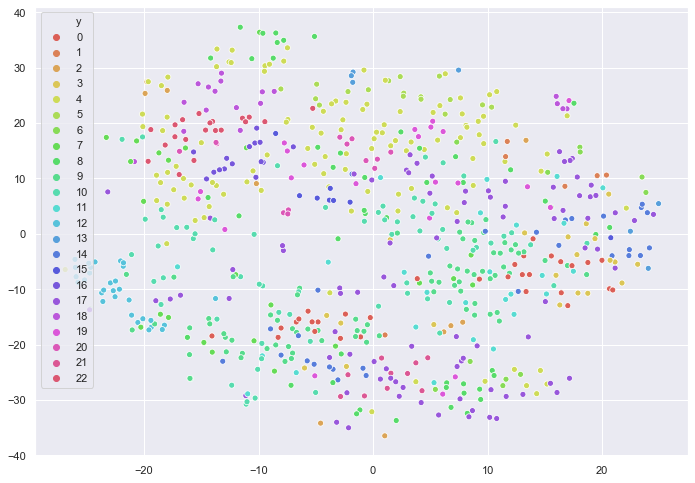

In [99]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=GMM_Cluster['y'], legend='full', palette=sns.color_palette("hls", 23))

In [161]:
N=len(GMM_Cluster['y'].unique())

In [195]:
fig = go.Figure(data=go.Scatter(showlegend=True,
    x=X_embedded[:,0],
    y= X_embedded[:,1],
    mode='markers',marker_colorscale=plotly.colors.sequential.Blackbody,
    marker_color=GMM_Cluster['y'],marker = dict(size=12), hovertext=players)
)

fig.update_layout(xaxis=dict(showgrid=True, zeroline=False, showticklabels=True),
    yaxis=dict(zeroline=True, gridcolor='rgb(255,255,255)'), xaxis_title="Principal Component 1",
    yaxis_title="Principal Component 2",
   #paper_bgcolor='rgb(255,255,255)',
    #plot_bgcolor='rgb(255,255,255)', 
                  height=800,font={"family": "Raleway", "size": 15})



fig.show()

In [183]:
fig['data'][0]['showlegend']=True

In [199]:
GMM_Cluster['Player'] = players

In [216]:
import plotly.express as px
fig = px.scatter(GMM_Cluster, x="tsne-2d-one", y="tsne-2d-two", color="y",
hover_data=['Player'], )
fig.update_layout(xaxis=dict(showgrid=True, zeroline=False, showticklabels=True),
    yaxis=dict(zeroline=True, gridcolor='rgb(255,255,255)'), xaxis_title="Principal Component 1",
    yaxis_title="Principal Component 2",
   #paper_bgcolor='rgb(255,255,255)',
    #plot_bgcolor='rgb(255,255,255)', 
                  height=800,font={"family": "Raleway", "size": 15})
fig.show()

In [237]:
GMM_Cluster.to_csv(r"C:\Users\aalimov002\Desktop\Deploy_dash\for_tsne.csv")

In [205]:
GMM_Cluster.shape

,y,tsne-2d-one,tsne-2d-two,Player
0,4,-9.439909,30.328367,A. Fedchuk


In [211]:
GMM_Cluster=GMM_Cluster[GMM_Cluster['y'] <6]

In [220]:
GMM_Cluster=pd.read_csv(r"C:\Users\aalimov002\Desktop\vizual\for_tsne.csv", index_col=None)

In [222]:
GMM_Cluster=GMM_Cluster.drop(['Unnamed: 0'],axis=1)

In [226]:
GMM_Cluster['Player2'] = GMM_Cluster['Player']
G

,y,tsne-2d-one,tsne-2d-two,Player,Player2
0,4,-9.439909,30.328367,A. Fedchuk,A. Fedchuk


In [229]:
for i in range(len(GMM_Cluster)):
    GMM_Cluster.at[i,'Player'] = 'Cluster ' +  str(GMM_Cluster.at[i,'y']) + ' ' +  GMM_Cluster.at[i,'Player2']

In [230]:
GMM_Cluster.head(1)

,y,tsne-2d-one,tsne-2d-two,Player,Player2
0,4,-9.439909,30.328367,Cluster 4 A. Fedchuk,A. Fedchuk


In [233]:
fig = go.Figure(data=go.Scatter(showlegend=False,
    x=X_embedded[:,0],
    y= X_embedded[:,1],
    mode='markers',marker_colorscale=plotly.colors.sequential.Magma,
    marker_color=GMM_Cluster['y'],marker = dict(size=12), hovertext=GMM_Cluster['Player'])
)

fig.update_layout(xaxis=dict(showgrid=True, zeroline=False, showticklabels=True),
    yaxis=dict(zeroline=True, gridcolor='rgb(255,255,255)'), xaxis_title="Principal Component 1",
    yaxis_title="Principal Component 2",
   #paper_bgcolor='rgb(255,255,255)',
    #plot_bgcolor='rgb(255,255,255)', 
                  height=800,font={"family": "Raleway", "size": 15})



fig.show()

In [234]:
GMM_Cluster

,y,tsne-2d-one,tsne-2d-two,Player,Player2
0,4,-9.439909,30.328367,Cluster 4 A. Fedchuk,A. Fedchuk
1,17,16.590607,4.222875,Cluster 17 A. Abazov,A. Abazov
2,17,11.625076,-29.353165,Cluster 17 A. Abramov,A. Abramov
3,10,-8.342758,12.286539,Cluster 10 A. Akhjadov,A. Akhjadov
4,17,24.486908,3.503012,Cluster 17 A. Aliev,A. Aliev
5,2,7.832221,-15.956349,Cluster 2 A. Antonov,A. Antonov
6,14,16.797821,2.495185,Cluster 14 A. Anyukov,A. Anyukov
7,9,-0.492284,-16.411640,Cluster 9 A. Aravin,A. Aravin
8,0,20.650100,-9.923782,Cluster 0 A. Bairyev,A. Bairyev
9,4,-14.749075,2.923594,Cluster 4 A. Batyutin,A. Batyutin
